In [97]:
# Vamos a generar un producto RGB de microfisica diurna 

from datetime import datetime
from goes_rgb.aws_interface import *
from goes_rgb.reader import *
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs  # Plot maps
import cartopy.feature as cfeature


# Vamos a hacer un pipeline simple de descarga de archivos GOES y posterior visualizacion
# Basandonos en el practico 6 de satelitales 

# Primero, vamos a descargar los archivos GOES para una fecha y hora especifica
download_goes_files_for_datetime(datetime(2018, 12, 13, 7, 0),channels=["C07","C15","C13"],product="ABI-L1b-RadF",satellite="noaa-goes16",local_dir="data")

# Listar los archivos descargados
archivos = os.listdir("data")
print("Archivos descargados:")
for archivo in archivos:    
    print(archivo)

OR_ABI-L1b-RadF-M3C07_G16_s20183470700356_e20183470711134_c20183470711170.nc ya existe, omitiendo descarga.
OR_ABI-L1b-RadF-M3C15_G16_s20183470700356_e20183470711129_c20183470711195.nc ya existe, omitiendo descarga.
OR_ABI-L1b-RadF-M3C13_G16_s20183470700356_e20183470711134_c20183470711195.nc ya existe, omitiendo descarga.
Archivos descargados:
OR_ABI-L1b-RadF-M3C13_G16_s20183470700356_e20183470711134_c20183470711195.nc
OR_ABI-L1b-RadF-M3C15_G16_s20183470700356_e20183470711129_c20183470711195.nc
OR_ABI-L1b-RadF-M3C07_G16_s20183470700356_e20183470711134_c20183470711170.nc


In [98]:
archivos

['OR_ABI-L1b-RadF-M3C13_G16_s20183470700356_e20183470711134_c20183470711195.nc',
 'OR_ABI-L1b-RadF-M3C15_G16_s20183470700356_e20183470711129_c20183470711195.nc',
 'OR_ABI-L1b-RadF-M3C07_G16_s20183470700356_e20183470711134_c20183470711170.nc']

In [99]:

imagenobj7 = open_goes_file("data/" + archivos[2])
imagenobj15 = open_goes_file("data/" + archivos[1])
imagenobj13 = open_goes_file("data/" + archivos[0])

metadato7 = imagenobj7.variables
metadato15 = imagenobj15.variables
metadato13 = imagenobj13.variables

########################################ES IGUAL PARA LAS 3 BANDAS ################
proyeccion=metadato13['goes_imager_projection'].attrs
altura=proyeccion['perspective_point_height']
semieje_may=proyeccion['semi_major_axis']
semieje_men=proyeccion['semi_minor_axis']
lon_cen=proyeccion['longitude_of_projection_origin']

#img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
#img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
x = imagenobj13.coords['x'].values * altura  
y = imagenobj13.coords['y'].values * altura
img_extent = (x[0], x[-1], y[-1], y[0])  # (xmin, xmax, ymin, ymax)

pol=semieje_may*altura/(semieje_may+altura)
ecu=semieje_men*altura/(semieje_may+altura)

##################################################################################


In [100]:
print("xmin:", x[0])
print("xmax:", x[-1])
print("ymin:", y[-1])
print("ymax:", y[0])


xmin: -5433892.69232443
xmax: 5433892.69232443
ymin: -5433892.69232443
ymax: 5433892.69232443


In [101]:
def calibrate_imag(imagen, metadato, U = 'T'):
  canal = int(metadato['band_id'][:])
  print('Calibrando la imagen', canal)
  if canal >=7:
      #Parámetros de calibracion
      fk1 = metadato['planck_fk1'].values # DN -> K
      fk2 = metadato['planck_fk2'].values
      bc1 = metadato['planck_bc1'].values
      bc2 = metadato['planck_bc2'].values

      imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2 - 273.15 # K -> C
      Unit = "Temperatura de Brillo [°C]"
  elif U=='Rad':
      pendiente= metadato['Rad'].scale_factor
      ordenada= metadato['Rad'].add_offset
      imag_cal =imagen*pendiente+ordenada
      Unit = "Radiancia ["+metadato['Rad'].units+"]"
  elif U=='Ref':
      raise("Not implemented yet")
      kapa0 = metadato2['kappa0'][0].data
      imag_cal = kapa0 * imagen
      Unit = "Reflectancia"
  return imag_cal

def realce_gama(V, A, gama, Vmin, Vmax):
    Vaux = (V - Vmin) / (Vmax - Vmin)
    Vaux[Vaux<0] = 0
    Vaux[Vaux>1] = 1
    Vout = A * Vaux**gama
    return Vout

In [102]:
# Coordenada del punto superior izquierdo del recorte (x0, y0) en metros
x0 = -500000
y0 = -2000000

Ny = 1400
Nx = 1400

# Convertir x/y en índices
c0 = np.argmin(np.abs(x - x0))  # índice columna más cercana a x0
f0 = np.argmin(np.abs(y - y0))  # índice fila más cercana a y0

# Extremos del recorte
c1 = c0 + Nx
f1 = f0 + Ny


########## Mismo reccorte que el del practico 6 ######################
# 
#  
# psize = 2000 # lado de pixel de referencia en m
# N = 5424 #numero de pixeles de referencia

# Nx = 2000 #numero de puntos del recorte en x
# Ny = 2000 #numero de puntos del recorte en x

# esc = 1#int(imag_cal.shape[0]/N)

# x0 = -1700000 # Coordenada x del limite superior izquierdo en m
# y0 = -100000 # Coordenada y del limite superior izquierdo en m

# f0 = int((img_extent[1] - y0) / psize*esc) #fila del angulo superior izquierdo
# c0 = int((img_extent[3] + x0) / psize*esc) #columna del angulo superior izquierdo
# f1 = int(f0 + Nx*esc) #fila del angulo inferior derecho
# c1 = int(c0 + Ny*esc) #columna del angulo inferior derecho


Calibrando la imagen 13
Calibrando la imagen 15
Calibrando la imagen 7


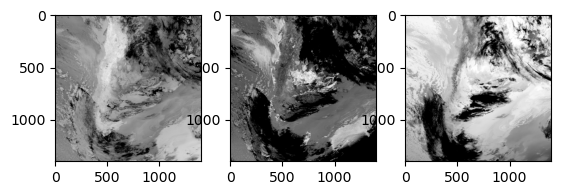

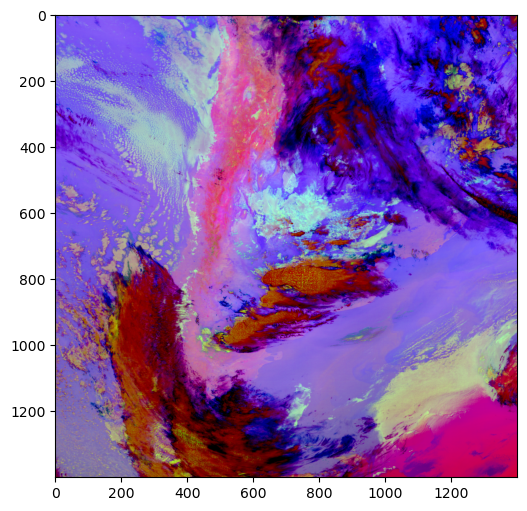

In [103]:
imagen13 = get_radiance_array(imagenobj13) #metadato13['Rad'][:].data
imagen15 = get_radiance_array(imagenobj15) #metadato15['Rad'][:].data
imagen7 = get_radiance_array(imagenobj7) #metadato7['Rad'][:].data

imag_calibrate13 = calibrate_imag(imagen13[f0:f1, c0:c1], metadato13)
imag_calibrate15 = calibrate_imag(imagen15[f0:f1, c0:c1], metadato15)
imag_calibrate7 =calibrate_imag(imagen7[f0:f1, c0:c1], metadato7)

[filas,columnas] = imag_calibrate7.shape

imagen_RGB=np.zeros([filas,columnas,3])

red_imagen = imag_calibrate15 - imag_calibrate13
green_imagen = imag_calibrate13 - imag_calibrate7
blue_imagen = imag_calibrate13

realce_red = realce_gama(red_imagen, 1, 1, -6.7, 2.6)
realce_green = realce_gama(green_imagen, 1, 1, -3.1, 5.2)
realce_blue = realce_gama(blue_imagen, 1,  1, -29.6, 19.5)


imagen_RGB[:,:,0] = realce_red
imagen_RGB[:,:,1] = realce_green
imagen_RGB[:,:,2] = realce_blue

plt.figure()
plt.subplot(131)
plt.imshow(realce_red, cmap='gray')

plt.subplot(132)
plt.imshow(realce_green, cmap='gray')

plt.subplot(133)
plt.imshow(realce_blue, cmap='gray')

plt.figure(figsize=(6,6))
plt.imshow(imagen_RGB)

# Exportar a GeoTIFF 

In [104]:
print(type(imagen_RGB))
print(imagen_RGB.shape)
crs = ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)#proyeccion geoestacionaria para Goes16

<class 'numpy.ndarray'>
(1400, 1400, 3)


In [105]:
crs   

<Projected CRS: +proj=geos +ellps=WGS84 +lon_0=-75.0 +lat_0=0.0 +h ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep Y)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [106]:
# Verificar el rango de valores que estan en la imagen, deberia ser entre 0 y 1
print("Rango de valores en la imagen:")
print("Rojo:", imagen_RGB[:, :, 0].min(), "-", imagen_RGB[:, :, 0].max())
print("Verde:", imagen_RGB[:, :, 1].min(), "-", imagen_RGB[:, :, 1].max())
print("Azul:", imagen_RGB[:, :, 2].min(), "-", imagen_RGB[:, :, 2].max())


Rango de valores en la imagen:
Rojo: 0.0 - 0.9710088968276978
Verde: 0.0 - 1.0
Azul: 0.0 - 1.0


In [107]:
#tenemos que hacer que los valores sean enteros de 8 bits 
# Convertir a uint8
imagen_RGB_uint= (imagen_RGB * 255).astype(np.uint8)


In [108]:
rgb_array = imagen_RGB_uint.transpose(2, 0, 1)  # (3, height, width)
rgb_array.shape

(3, 1400, 1400)

In [114]:
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

# cambiamos el extent a la forma que necesita rasterio
# Teniendo en cuenta que esto es un recorte, por ende no es el extent de la imagen original
height, width = rgb_array.shape[1:]  # (3, H, W)
# Extraemos el CRS de cartopy
crs_rio = CRS.from_string(crs.proj4_init)
# Defino el extent para el recorte
img_extent_recorte = (x[c0], y[f1], x[c1], y[f0])  # xmin, ymin, xmax, ymax

transform = from_bounds(*img_extent_recorte, width=width, height=height)

with rasterio.open(
    "output_rgb_recorte.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=3,
    dtype=rgb_array.dtype,
    crs=crs_rio,
    transform=transform,
) as dst:
    # dst.write(rgb_array[:, f0:f1, c0:c1][0], 1)  # R
    # dst.write(rgb_array[:, f0:f1, c0:c1][1], 2)  # G
    # dst.write(rgb_array[:, f0:f1, c0:c1][2], 3)  # B
    dst.write(rgb_array[0], 1)  # Red
    dst.write(rgb_array[1], 2)  # Green
    dst.write(rgb_array[2], 3)  # Blue



In [115]:
with rasterio.open("output_rgb.tif") as src:
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Bounds:", src.bounds)
    print("Width x Height:", src.width, "x", src.height)
    print("Band Count:", src.count)


CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown based on WGS 84 ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +ellps=WGS84 +lon_0=-75.0 +lat_0=0.0 +h=35786023.0 +x_0=0 +y_0=0 +units=m +sweep=y +no_defs"]]
Transform: | 7762.70, 0.00,-5433892.69|
| 0.00,-7762.70, 5433892.69|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=-5433892.69232443, bottom=-5433892.69232443, right=5433892.69232443, top=5433892.69232443)
Width x Height: 1400 x 1400
Band Count: 3
